In [ ]:
name_of_experiment = "term_vectors"
output_file = "eval.json"

In [9]:
# Посчитать метрики
from documents import FileSystem
import asyncio
from pathlib import Path
import json
from lexis import extract_number


async def eval(name_of_file_to_save: str | Path, name_of_experiment: str | Path):
    base_path = Path("data") / "eval"

    eval_dict = {
        "all_docs": 0,
        "self_top1": 0,
        "soft": 0,
        "hard": 0,
        "avg": 0,
        "no_relevant": 0,
    }

    with open(
        base_path / (name_of_experiment + "_performance.json"), encoding="utf-8"
    ) as file:
        methods = list(json.load(file).keys())

    metrics = {method: eval_dict.copy() for method in methods}

    list_of_files = list((base_path / name_of_experiment).iterdir())

    for file_path in list_of_files:
        with open(file_path, encoding="utf-8") as file:
            data = json.load(file)

        citations = list(map(extract_number, data["56"]))
        cluster = list(map(extract_number, data["cluster"]))

        evaluate_data = set(citations)
        # evaluate_data = set(citations + cluster)

        for extractor_name, relevant_docs in data["relevant"].items():
            if extractor_name not in metrics.keys():
                continue

            relevant = list(set(map(extract_number, relevant_docs)))[:20]

            if len(evaluate_data) > 0:
                num_of_hits = 0
                for doc in evaluate_data:
                    if doc in relevant:
                        num_of_hits += 1

                metrics[extractor_name]["soft"] += num_of_hits > 0
                if len(evaluate_data) > 1:
                    metrics[extractor_name]["avg"] += num_of_hits / len(evaluate_data)
                    metrics[extractor_name]["hard"] += num_of_hits == len(evaluate_data)
                metrics[extractor_name]["all_docs"] += 1

            if relevant:
                metrics[extractor_name]["self_top1"] += relevant[0] == file_path.stem
            else:
                metrics[extractor_name]["no_relevant"] += 1

    for extractor_name, eval in metrics.items():
        print(extractor_name, "metrics:")
        for metric in eval.keys():
            if metric in ["self_top1", "no_relevant"]:
                eval[metric] = round(eval[metric] / len(list_of_files))
            elif metric != "all_docs":
                eval[metric] = round(eval[metric] / eval["all_docs"], 4)

            print(metric, "-", round(eval[metric], 4))
        print()

    with open(base_path / name_of_file_to_save, "w+") as file:
        json.dump(metrics, file, ensure_ascii=False, indent=4)


await eval(output_file, name_of_experiment)
print("Метрики посчитаны")

YAKE metrics:
all_docs - 47
self_top1 - 0
soft - 0.7234
hard - 0.0851
avg - 0.3696
no_relevant - 0

multilingual-mpnet metrics:
all_docs - 47
self_top1 - 0
soft - 0.6596
hard - 0.0638
avg - 0.311
no_relevant - 0

e5-large metrics:
all_docs - 47
self_top1 - 0
soft - 0.766
hard - 0.1277
avg - 0.354
no_relevant - 0

Метрики посчитаны


,YAKE,multilingual-mpnet,e5-large
soft,0.7234,0.6809,0.7234
hard,0.0851,0.0638,0.1064
avg,0.3430,0.3007,0.3250


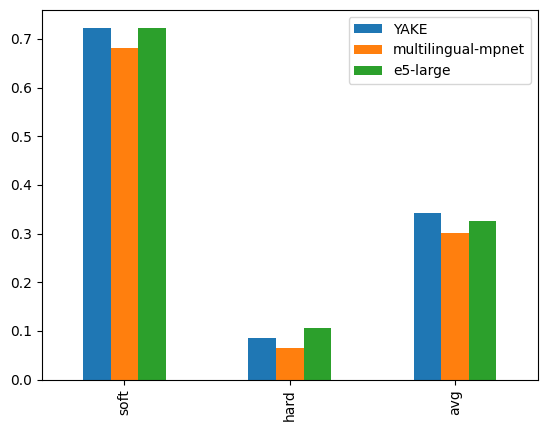

In [3]:
# Вывести метрики по разным моделям
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = Path("data") / "eval"

with open(BASE_PATH / "eval.json") as file:
    rawdata = json.load(file)
data = {i: {} for i in rawdata.keys()}
for k, v in rawdata.items():
    for k1, v1 in v.items():
        if k1 not in ["all_docs", "self_top1", "no_relevant"]:
            data[k][k1] = v1

data = pd.DataFrame(data)

data.plot.bar()
pd.DataFrame(data)

In [5]:
a = {
    "YAKE": {"soft": 0.6835, "avg": 0.2887, "hard": 0.0506},
    "multilingual-mpnet": {"soft": 0.6203, "avg": 0.2289, "hard": 0.0253},
    "e5-large": {"soft": 0.6329, "avg": 0.2673, "hard": 0.0380},
}

pd.DataFrame(a)

,YAKE,multilingual-mpnet,e5-large
soft,0.6835,0.6203,0.6329
avg,0.2887,0.2289,0.2673
hard,0.0506,0.0253,0.0380


In [2]:
# UPDATE 56 field
from documents import FileSystem
import json


async for doc in FileSystem("data\\raw\\skolkovo"):
    with open("data\\eval\\kwe\\" + doc.id + ".json", encoding="utf-8") as file:
        data = json.load(file)
    data["56"] = doc.citations
    with open("data\\eval\\kwe\\" + doc.id + ".json", "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [8]:
# UPDATE cluster field
from documents import FileSystem
import json


async for doc in FileSystem("data\\raw\\clusters"):
    with open("data\\eval\\ckwe\\" + doc.id + ".json", encoding="utf-8") as file:
        data = json.load(file)
    data["cluster"] = [i.split("_")[0] for i in doc.cluster]
    with open("data\\eval\\ckwe\\" + doc.id + ".json", "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [11]:
# процент 56 доков в кластере
import numpy as np

num = []
base_path = Path("data") / "eval"
BASE_PATH = Path("data") / "eval"

list_of_files = list((base_path / "ckwe").iterdir())

for file_path in list_of_files:
    with open(file_path, encoding="utf-8") as file:
        data = json.load(file)
    num.append(len(set(data["cluster"]) & set(data["56"])) / len(data["56"]))
print(np.mean(num))
# data = {i: {} for i in rawdata.keys()}
# for k, v in rawdata.items():
#     for k1, v1 in v.items():
#         if k1 not in ["all_docs", "self_top1", "no_relevant"]:
#             data[k][k1] = v1

0.6463690476190477


In [10]:
# Сравнить готовые терм вектора с полученными моей системой
#

from pathlib import Path
from lexis import lemmatize_ru_word
from documents import FileSystem
import pandas as pd
import json

BASE_PATH = Path("data") / "eval"

# old_docs = old system termvectors (keywords)

old_docs = {}

raw_data = pd.read_csv(BASE_PATH / "80_with_TV.csv", delimiter=";")

for idx, raw in raw_data.iterrows():
    id_mass = raw["Документ"].split("_")
    id = id_mass[-1] + id_mass[0] + id_mass[1]

    old_docs[id] = []
    for num in range(2, 52):
        word = raw[str(num)].split("~")[0]
        old_docs[id].append(lemmatize_ru_word(word))

# new_docs = my keywords

new_docs = {}

list_of_files = list((BASE_PATH / "kwe").iterdir())

for file_path in list_of_files:
    with open(file_path, encoding="utf-8") as file:
        data = json.load(file)
    new_docs[file_path.stem] = {
        extractor_name: list(map(lemmatize_ru_word, kws))
        for extractor_name, kws in data["keywords"].items()
    }

# evaluation dicts

eval_dict = {
    "all_docs": 0,
    "same_top1": 0,
    "soft": 0,
    "hard": 0,
    "avg": 0,
    "no_match": 0,
}

with open(
    BASE_PATH / (name_of_experiment + "_performance.json"), encoding="utf-8"
) as file:
    performance = json.load(file)


metrics = {method: eval_dict.copy() for method in performance.keys()}

# evaluation
# bebra = []
for new_doc_id, new_kws in new_docs.items():
    try:
        old_kw = old_docs[new_doc_id]
        for extractor_name, new_kw in new_kws.items():
            hits = 0
            for new_term in new_kw:
                if new_term in old_kw:
                    hits += 1
                # if "cls" in new_term.lower():
                #     bebra.append(new_term)

            metrics[extractor_name]["same_top1"] += new_kw[0] == old_kw[0]
            metrics[extractor_name]["soft"] += hits > 0
            metrics[extractor_name]["avg"] += hits / len(old_kw)
            metrics[extractor_name]["hard"] += hits == len(old_kw)
            metrics[extractor_name]["no_match"] += hits == 0
            metrics[extractor_name]["all_docs"] += 1

    except KeyError:
        continue

for extractor_name, eval in metrics.items():
    # print(extractor_name, "metrics:")
    for metric in eval.keys():
        if metric != "all_docs":
            eval[metric] = round(eval[metric] / eval["all_docs"], 2)

print("Метрики посчитаны")
# print(len(bebra), bebra)

Метрики посчитаны
8 ['[cls]', '[cls]', '[cls]', '[cls]', '[cls]', 'clsi', '[cls]', '[cls]']


            YAKE  standart  ru-longformer  bi-encoder-ru  rubert-tiny  \
all_docs   78.00     78.00          78.00          78.00        78.00   
same_top1   0.46      0.08           0.05           0.05         0.08   
soft        1.00      1.00           0.99           0.99         1.00   
hard        0.00      0.00           0.00           0.00         0.00   
avg         0.57      0.20           0.22           0.15         0.24   
no_match    0.00      0.00           0.01           0.01         0.00   

           all-mpnet  multi-qa-mpnet  multilingual-mpnet  allenai-specter  \
all_docs       78.00           78.00               78.00            78.00   
same_top1       0.05            0.03                0.01             0.00   
soft            1.00            1.00                1.00             1.00   
hard            0.00            0.00                0.00             0.00   
avg             0.14            0.13                0.17             0.15   
no_match        0.00      

<AxesSubplot: >

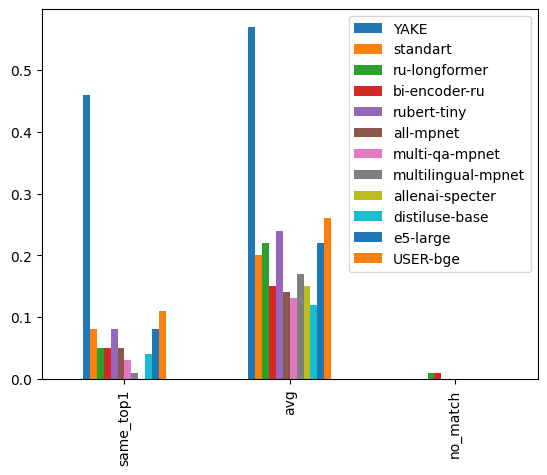

In [11]:
df = pd.DataFrame(metrics)
print(df)
df = df.drop(["soft", "all_docs", "hard"])
df.plot.bar()

In [ ]:
# Оценить скорость работы алгоритмов
#

from documents import FileSystem
import numpy as np

doc_dict = {doc.id async for doc in FileSystem("data\\raw\\skolkovo")}

for extractor_name, value_dict in performance.items():
    # TODO: Дописать + нарисовать графики
    print(f"Среднее время - {np.mean(value_dict["time"])}сек (общее) {1}симв/сек")